In [1]:
%matplotlib widget
#%matplotlib inline

In [28]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import os
import imageio 
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
#mpl.rc('ytick', labelsize=12)

rng_seed_1 = 1945
#np.random.seed(rng_seed)
#tf.random.set_seed(rng_seed)  # uncomment to have reproducible NN initialization 
rand1 = np.random.RandomState(rng_seed_1) 

In [3]:
Nx = 201 
Ny = 101 
Nsamp = 100
x_frac = 0.2  # fraction of the total image size spanned by each "bell" (in x direction) 
y_frac = 0.4  # -"- in y direction 
x_offset_frac_min = -0.5  # random offsets are drawn from a uniform in x and y distribution,  
x_offset_frac_max = 0.5   # with min and max offsets specified here as a fraction of the total image size 
y_offset_frac_min = -0.2 
y_offset_frac_max = 0.2 
train_frac = 0.8  # fraction of the data used for training, the rest being used for validation
Ntest = 40  # number of images used for testing/evaluation after the training is done 

In [4]:
ofs_x = rand1.uniform(x_offset_frac_min, x_offset_frac_max, Nsamp) 
ofs_y = rand1.uniform(y_offset_frac_min, y_offset_frac_max, Nsamp) 

In [5]:
#offsets = np.array(zip(ofs_x, ofs_y), dtype=np.float32)  # python2 
offsets = np.array(list(zip(ofs_x, ofs_y)), dtype=np.float32)  # python3 

In [6]:
offsets.shape

(100, 2)

In [7]:
# tensorflow models require input data in a 4D array format: number of images, size1, size2, number of channels
# Here, Nsamp 2D images of randomly offset "bells" are generated
def gener_2Dbell_training_data_4Dtensor(Nx, Ny, x_frac, y_frac, offsets, Nchannels=1): 
  #Ndims = offsets.shape[1] 
  N_data_instances  = offsets.shape[0] 
  x0 = np.linspace(-1., 1., Nx) 
  y0 = np.linspace(-1., 1., Ny) 
  data_set = np.zeros([N_data_instances, Nx, Ny, Nchannels], dtype=np.float32) 
  for i in np.arange(N_data_instances): 
    x = x0 -offsets[i, 0] 
    y = y0 -offsets[i, 1] 
    for i_x in np.arange(Nx): 
      for i_y in np.arange(Ny): 
        dst = max(0.0, -(x[i_x] -x_frac) *(x[i_x] +x_frac)) *max(0.0, -(y[i_y] -y_frac) *(y[i_y] +y_frac))
        data_set[i, i_x, i_y, :] = 1. *dst 
  return data_set 


In [8]:
data_set = gener_2Dbell_training_data_4Dtensor(Nx, Ny, x_frac, y_frac, offsets)

In [9]:
data_set.shape

(100, 201, 101, 1)

In [11]:
Ntrain = int(train_frac * Nsamp)
Ntrain

80

In [12]:
x = data_set[0:Ntrain,:,:,:]
x_val = data_set[Ntrain:,:,:,:]
y = offsets[0:Ntrain,:]
y_val = offsets[Ntrain:,:]

In [13]:
max_height = x[0,:,:,0].max()  # for data generated as above, max val is the same for all images; 1-channel images
x /= max_height 
x_val /= max_height

In [14]:
model2 = keras.models.Sequential([
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, activation="relu", padding="same",
                            input_shape=[Nx, Ny, 1]),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(32, kernel_size=4, strides=2, activation="relu", padding="same"),
        keras.layers.Conv2D(32, kernel_size=4, strides=2, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Conv2D(64, kernel_size=4, strides=1, activation="relu", padding="same"),
        keras.layers.Conv2D(64, kernel_size=4, strides=1, activation="relu", padding="same"),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(2, activation="relu")
])

2022-07-12 22:19:24.265036: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/mpich/lib:/home/vagrant/.local/lib
2022-07-12 22:19:24.265092: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-12 22:19:24.265140: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rs33.local): /proc/driver/nvidia/version does not exist
2022-07-12 22:19:24.283984: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199895000 Hz
2022-07-12 22:19:24.287243: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x392bdc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-12 22:19:24.287261: I tensorflow/compiler/xla/service/service.cc:176]   Stream

In [15]:
model2.compile(optimizer='sgd', loss='mse', metrics=['MeanAbsoluteError'])

In [16]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 101, 51, 16)       272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 13, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 7, 32)         16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 3, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 3, 64)          32832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 3, 64)          6

In [17]:
history2 = model2.fit(x, y, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
3/3 [==============================] - 0s 155ms/step - loss: 0.0455 - mean_absolute_error: 0.1685 - val_loss: 0.0578 - val_mean_absolute_error: 0.1906
Epoch 2/50
3/3 [==============================] - 0s 98ms/step - loss: 0.0454 - mean_absolute_error: 0.1690 - val_loss: 0.0574 - val_mean_absolute_error: 0.1900
Epoch 3/50
3/3 [==============================] - 0s 84ms/step - loss: 0.0447 - mean_absolute_error: 0.1678 - val_loss: 0.0571 - val_mean_absolute_error: 0.1894
Epoch 4/50
3/3 [==============================] - 0s 98ms/step - loss: 0.0449 - mean_absolute_error: 0.1677 - val_loss: 0.0572 - val_mean_absolute_error: 0.1898
Epoch 5/50
3/3 [==============================] - 0s 76ms/step - loss: 0.0449 - mean_absolute_error: 0.1686 - val_loss: 0.0570 - val_mean_absolute_error: 0.1896
Epoch 6/50
3/3 [==============================] - 0s 76ms/step - loss: 0.0448 - mean_absolute_error: 0.1679 - val_loss: 0.0563 - val_mean_absolute_error: 0.1884
Epoch 7/50
3/3 [=================

In [18]:
# generate data for testing the trained model: 
ofs_x_test = rand1.uniform(x_offset_frac_min, x_offset_frac_max, Ntest) 
ofs_y_test = rand1.uniform(y_offset_frac_min, y_offset_frac_max, Ntest) 
#offsets_test = np.array(zip(ofs_x_test, ofs_y_test), dtype=np.float32)  # python2 
offsets_test = np.array(list(zip(ofs_x_test, ofs_y_test)), dtype=np.float32)  # python3 

data_set_test = gener_2Dbell_training_data_4Dtensor(Nx, Ny, x_frac, y_frac, offsets_test)

In [19]:
data_set_test.shape

(40, 201, 101, 1)

In [20]:
x_test = data_set_test / data_set_test[0,:,:,:].max()
y_test = offsets_test

In [21]:
model2.evaluate(x_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0331 - mean_absolute_error: 0.1424


[0.03311514854431152, 0.14241471886634827]

In [22]:
from tensorflow.keras.utils import plot_model

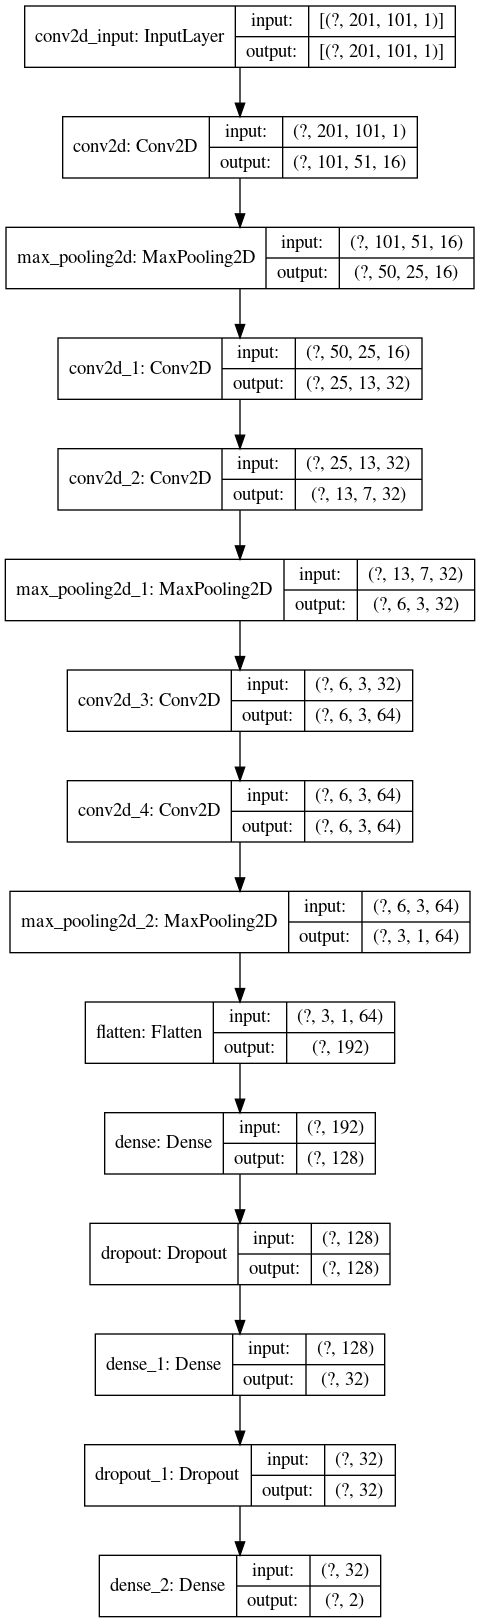

In [23]:
plot_model(model2, 'model2.png', show_shapes=True)

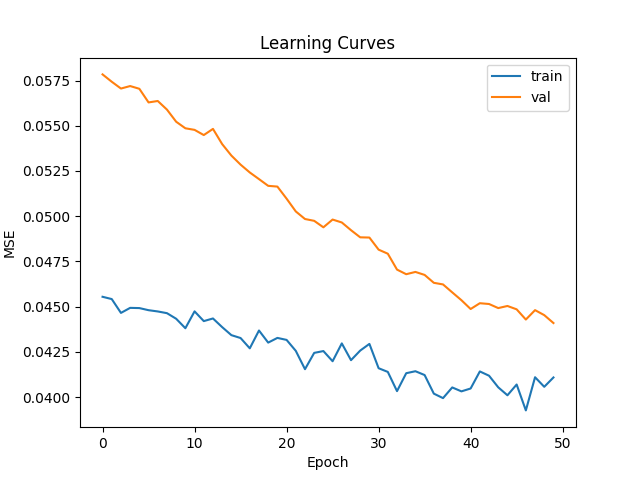

In [24]:
plt.figure()
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='val')
plt.legend()
plt.show()

In [27]:
# prediction requires a 4D array as input:
i = 11
model2.predict(x_test[i:i+1])

array([[0.03581742, 0.        ]], dtype=float32)

In [30]:
# the model trained on a small data set ends up severely undertrained:
model2.predict(x_test)

array([[0.08767852, 0.        ],
       [0.02182552, 0.        ],
       [0.0509011 , 0.        ],
       [0.        , 0.        ],
       [0.04527604, 0.        ],
       [0.02016333, 0.        ],
       [0.08910787, 0.        ],
       [0.        , 0.        ],
       [0.09111042, 0.        ],
       [0.08647018, 0.        ],
       [0.        , 0.        ],
       [0.03581742, 0.        ],
       [0.07543723, 0.        ],
       [0.        , 0.        ],
       [0.04520972, 0.        ],
       [0.00235881, 0.        ],
       [0.08861624, 0.        ],
       [0.0032909 , 0.        ],
       [0.        , 0.        ],
       [0.01321018, 0.        ],
       [0.09221138, 0.        ],
       [0.08796823, 0.        ],
       [0.05565519, 0.        ],
       [0.        , 0.        ],
       [0.00175027, 0.        ],
       [0.01306756, 0.        ],
       [0.0145669 , 0.        ],
       [0.08967535, 0.        ],
       [0.03357993, 0.        ],
       [0.02027695, 0.        ],
       [0.

In [32]:
y_test

array([[ 3.18373561e-01, -5.72925247e-02],
       [-4.80918474e-02,  1.26988456e-01],
       [ 7.57749677e-02, -1.29318088e-01],
       [-4.78198707e-01,  1.84903130e-01],
       [ 5.06473146e-02, -1.19608119e-01],
       [-5.18710762e-02,  7.41489083e-02],
       [ 3.86783779e-01, -5.28546944e-02],
       [-4.70613986e-01, -2.30725445e-02],
       [ 4.04488623e-01,  1.69632941e-01],
       [ 2.82445043e-01,  1.64867371e-01],
       [-1.80649757e-01,  1.75069630e-01],
       [ 1.19127091e-02,  9.62938741e-02],
       [ 2.14113116e-01,  7.98054412e-02],
       [-3.23792964e-01,  5.69682717e-02],
       [ 4.57549952e-02, -1.52057648e-01],
       [-2.22230792e-01, -1.31977588e-01],
       [ 4.34090734e-01, -1.34982066e-02],
       [-2.36453786e-01, -1.51883036e-01],
       [-2.90986776e-01,  4.68769250e-03],
       [-1.08067960e-01,  4.66073602e-02],
       [ 3.87081742e-01,  1.67266712e-01],
       [ 3.81357282e-01, -1.06435701e-01],
       [ 9.65912119e-02, -1.72461271e-01],
       [-1.

In [33]:
# Note that the predictions are all non-negative, which I (Ilya) think means it's not correct 
# to use activation="relu" in the model in this setting (at least in the final layer)